## Convolutional neural network
Tutorial on how to train a convolutional neural network to predict protein subcellular localization.


In [23]:
# Import all the necessary modules
import os
import sys
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,optimizer=None,device=cpu,floatX=float32"
sys.path = [p for p in sys.path if ".local/lib/python3.8/site-packages" not in p]
import numpy as np
import theano
import theano.tensor as T
import lasagne
from confusionmatrix import ConfusionMatrix
from utils import iterate_minibatches
import matplotlib.pyplot as plt
import time
import itertools
%matplotlib inline

### Hyperparameter of the Network

In [ ]:
batch_size = 128
seq_len = 400
n_feat = 20
n_hid = 30
n_class = 10
lr = 0.005
n_filt = 10
drop_prob = 0.5

# Number of epochs
num_epochs = 20


### Building the network
The first thing that we have to do is to define the network architecture. Here we are going to use an input layer, two convolutional layers with max pooling, a dense layer and an output layer. These are the steps that we are going to follow:

1.- Specify the hyperparameters of the network:

2.- Define the input variables to our network:

In [25]:
# We use ftensor3 because the protein data is a 3D-matrix in float32 
input_var = T.ftensor3('inputs')
# ivector because the labels is a single dimensional vector of integers
target_var = T.ivector('targets')

# Dummy data to check the size of the layers during the building of the network
X = np.random.randint(0,10,size=(batch_size,seq_len,n_feat)).astype('float32')
Xmask = np.ones((batch_size,seq_len)).astype('float32')

3.- Define the layers of the network:

In [26]:
# Input layer, holds the shape of the data
l_in = lasagne.layers.InputLayer(shape=(batch_size, seq_len, n_feat), input_var=input_var, name='Input')
print('Input layer: {}'.format(
    lasagne.layers.get_output(l_in, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Shuffle shape to be properly read by the CNN layer
l_shu = lasagne.layers.DimshuffleLayer(l_in, (0,2,1))

print('DimshuffleLayer layer: {}'.format(
    lasagne.layers.get_output(l_shu, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Convolutional layers with different filter size
l_conv_a = lasagne.layers.Conv1DLayer(l_shu, num_filters=n_filt, pad='same', stride=1, 
                                      filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
print('Convolutional layer size 3: {}'.format(
    lasagne.layers.get_output(l_conv_a, inputs={l_in: input_var}).eval({input_var: X}).shape))

l_conv_b = lasagne.layers.Conv1DLayer(l_shu, num_filters=n_filt, pad='same', stride=1, 
                                      filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
print('Convolutional layer size 5: {}'.format(
    lasagne.layers.get_output(l_conv_b, inputs={l_in: input_var}).eval({input_var: X}).shape))

# The output is concatenated
l_conc = lasagne.layers.ConcatLayer([l_conv_a, l_conv_b], axis=1)
print('Concatenated convolutional layers: {}'.format(
    lasagne.layers.get_output(l_conc, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Second CNN layer
l_conv_final = lasagne.layers.Conv1DLayer(l_conc, num_filters=n_filt*2, pad='same', 
                                          stride=1, filter_size=3, 
                                          nonlinearity=lasagne.nonlinearities.rectify)
print('Final convolutional layer: {}'.format(
    lasagne.layers.get_output(l_conv_final, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Max pooling is performed to downsample the input and reduce its dimensionality
final_max_pool = lasagne.layers.MaxPool1DLayer(l_conv_final, 5)
print('Max pool layer: {}'.format(
    lasagne.layers.get_output(final_max_pool, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Dense layer with ReLu activation function
l_dense = lasagne.layers.DenseLayer(final_max_pool, num_units=n_hid, name="Dense",
                                    nonlinearity=lasagne.nonlinearities.rectify)
print('Dense layer: {}'.format(
    lasagne.layers.get_output(l_dense, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Output layer with a Softmax activation function
l_out = lasagne.layers.DenseLayer(lasagne.layers.dropout(l_dense, p=drop_prob), num_units=n_class, name="Softmax", 
                                  nonlinearity=lasagne.nonlinearities.softmax)
print('Output layer: {}'.format(
    lasagne.layers.get_output(l_out, inputs={l_in: input_var}).eval({input_var: X}).shape))

Input layer: (128, 400, 20)
DimshuffleLayer layer: (128, 20, 400)
Convolutional layer size 3: (128, 10, 400)
Convolutional layer size 5: (128, 10, 400)
Concatenated convolutional layers: (128, 20, 400)
Final convolutional layer: (128, 20, 400)
Max pool layer: (128, 20, 80)
Dense layer: (128, 30)
Output layer: (128, 10)


4.- Calculate the prediction and network loss for the training set and update the network weights:

In [27]:
# Get output training, deterministic=False is used for training
prediction = lasagne.layers.get_output(l_out, inputs={l_in: input_var}, deterministic=False)

# Calculate the categorical cross entropy between the labels and the prediction
t_loss = T.nnet.categorical_crossentropy(prediction, target_var)

# Training loss
loss = T.mean(t_loss)

# Parameters
params = lasagne.layers.get_all_params([l_out], trainable=True)

# Get the network gradients and perform total norm constraint normalization
all_grads = lasagne.updates.total_norm_constraint(T.grad(loss, params),3)

# Update parameters using ADAM 
updates = lasagne.updates.adam(all_grads, params, learning_rate=lr)

5.- Calculate the prediction and network loss for the validation set:

In [28]:
# Get output validation, deterministic=True is only use for validation
val_prediction = lasagne.layers.get_output(l_out, inputs={l_in: input_var}, deterministic=True)

# Calculate the categorical cross entropy between the labels and the prediction
t_val_loss = lasagne.objectives.categorical_crossentropy(val_prediction, target_var)

# Validation loss 
val_loss = T.mean(t_val_loss)

6.- Build theano functions: 

In [29]:
# Build functions
train_fn = theano.function([input_var, target_var], [loss, prediction], updates=updates)
val_fn = theano.function([input_var, target_var], [val_loss, val_prediction])

### Load dataset
Once that the network is built, the next step is to load the training and the validation set

In [30]:
# Load the encoded protein sequences, labels and masks
# The masks are not needed for the FFN or CNN models
train = np.load('data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
print(X_train.shape)

(2423, 400, 20)


In [31]:
validation = np.load('data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']
print(X_val.shape)

(635, 400, 20)


### Training
Once that the data is ready and the network compiled we can start with the training of the model.
Here we define the number of epochs that we want to perform 

In [32]:
# Lists to save loss and accuracy of each epoch
loss_training = []
loss_validation = []
acc_training = []
acc_validation = []
start_time = time.time()
min_val_loss = float("inf")

# Start training 
for epoch in range(num_epochs):
    
    # Full pass training set
    train_err = 0
    train_batches = 0
    confusion_train = ConfusionMatrix(n_class)

    # Generate minibatches and train on each one of them
    for batch in iterate_minibatches(X_train.astype(np.float32), y_train.astype(np.int32), 
                                     mask_train.astype(np.float32), batch_size, shuffle=True, sort_len=False):
        # Inputs to the network
        inputs, targets, in_masks = batch
        # Calculate loss and prediction
        tr_err, predict = train_fn(inputs, targets)
        train_err += tr_err
        train_batches += 1
        # Get the predicted class, the one with the maximum likelihood
        preds = np.argmax(predict, axis=-1)
        confusion_train.batch_add(targets, preds)
    
    # Average loss and accuracy
    train_loss = train_err / train_batches
    train_accuracy = confusion_train.accuracy()
    cf_train = confusion_train.ret_mat()

    val_err = 0
    val_batches = 0
    confusion_valid = ConfusionMatrix(n_class)

    # Generate minibatches and validate on each one of them, same procedure as before
    for batch in iterate_minibatches(X_val.astype(np.float32), y_val.astype(np.int32), 
                                     mask_val.astype(np.float32), batch_size, shuffle=True, sort_len=False):
        inputs, targets, in_masks = batch
        err, predict_val = val_fn(inputs, targets)
        val_err += err
        val_batches += 1
        preds = np.argmax(predict_val, axis=-1)
        confusion_valid.batch_add(targets, preds)

    val_loss = val_err / val_batches
    val_accuracy = confusion_valid.accuracy()
    cf_val = confusion_valid.ret_mat()
    
    loss_training.append(train_loss)
    loss_validation.append(val_loss)
    acc_training.append(train_accuracy)
    acc_validation.append(val_accuracy)
    
    # Save the model parameters at the epoch with the lowest validation loss
    if min_val_loss > val_loss:
        min_val_loss = val_loss
        np.savez('params/CNN_params.npz', *lasagne.layers.get_all_param_values(l_out))
    
    print("Epoch {} of {} time elapsed {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_loss))
    print("  validation loss:\t\t{:.6f}".format(val_loss))
    print("  training accuracy:\t\t{:.2f} %".format(train_accuracy * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_accuracy * 100))

Epoch 1 of 20 time elapsed 2.219s
  training loss:		2.269945
  validation loss:		1.919781
  training accuracy:		24.59 %
  validation accuracy:		34.22 %
Epoch 2 of 20 time elapsed 4.380s
  training loss:		1.866272
  validation loss:		1.734797
  training accuracy:		35.61 %
  validation accuracy:		37.19 %
Epoch 3 of 20 time elapsed 6.562s
  training loss:		1.712023
  validation loss:		1.592307
  training accuracy:		41.08 %
  validation accuracy:		42.81 %
Epoch 4 of 20 time elapsed 8.873s
  training loss:		1.612840
  validation loss:		1.559277
  training accuracy:		42.72 %
  validation accuracy:		45.00 %
Epoch 5 of 20 time elapsed 11.010s
  training loss:		1.562223
  validation loss:		1.576367
  training accuracy:		46.01 %
  validation accuracy:		43.75 %
Epoch 6 of 20 time elapsed 13.055s
  training loss:		1.529276
  validation loss:		1.635715
  training accuracy:		46.18 %
  validation accuracy:		42.97 %
Epoch 7 of 20 time elapsed 15.177s
  training loss:		1.510727
  validation loss:		1.58

In [33]:
print("Minimum validation loss: {:.6f}".format(min_val_loss))

Minimum validation loss: 1.542161


### Model loss and accuracy
Here we plot the loss and the accuracy for the training and validation set at each epoch.

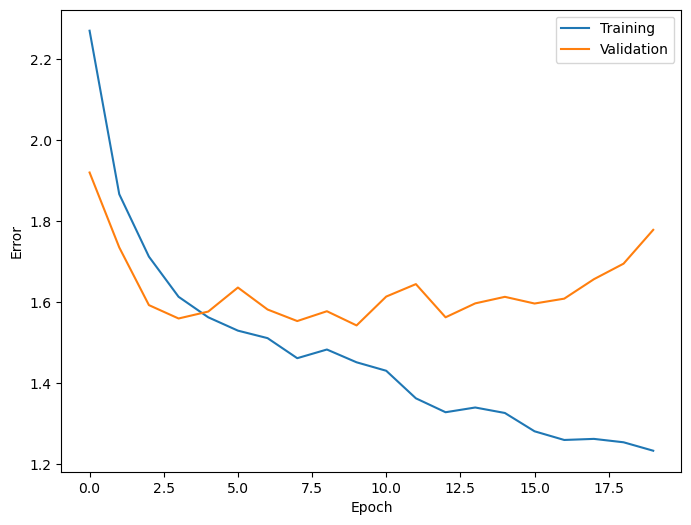

In [34]:
x_axis = range(num_epochs)
plt.figure(figsize=(8,6))
plt.plot(x_axis,loss_training)
plt.plot(x_axis,loss_validation)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(('Training','Validation'))

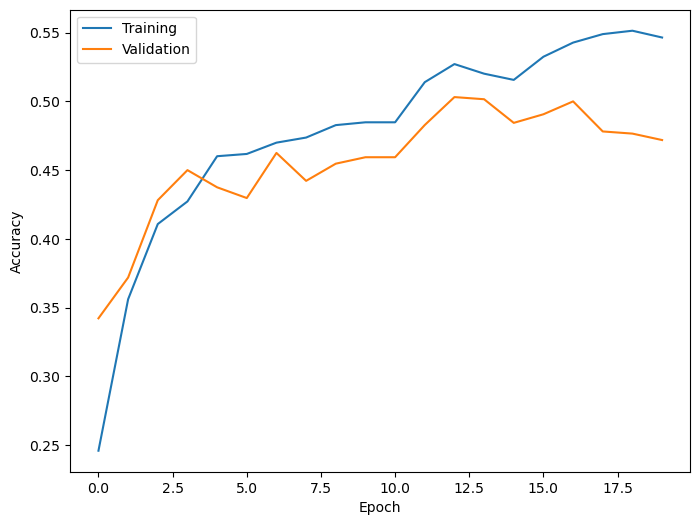

In [35]:
plt.figure(figsize=(8,6))
plt.plot(x_axis,acc_training)
plt.plot(x_axis,acc_validation)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training','Validation'));

### Confusion matrix
The confusion matrix allows us to visualize how well is predicted each class and which are the most common misclassifications.

Text(0.5, 29.59340240214948, 'Predicted location')

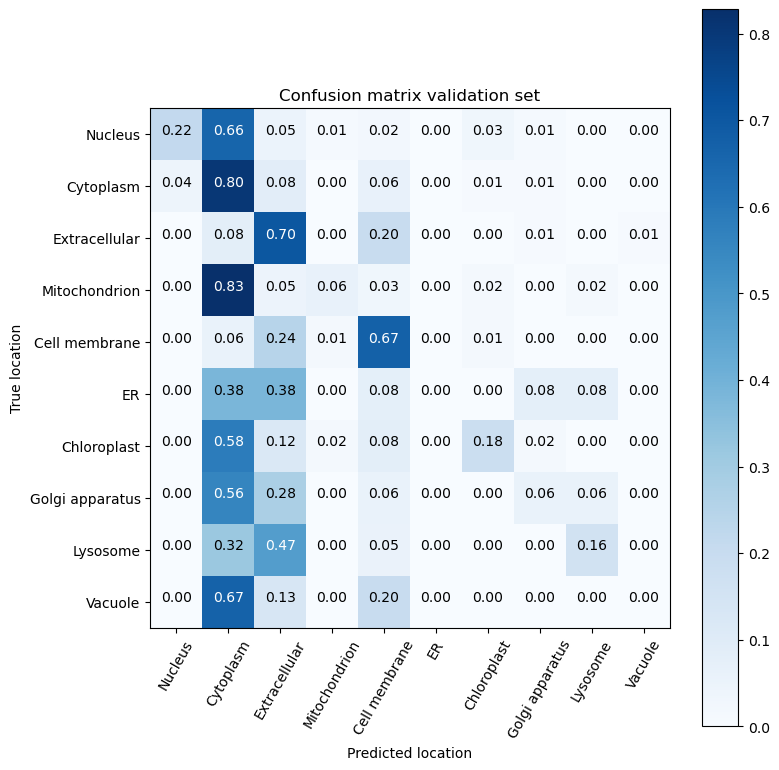

In [36]:
# Plot confusion matrix 
# Code based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
Norm = True
plt.figure(figsize=(8,8))
cmap=plt.cm.Blues   

if Norm:
    cf_val = cf_val.astype('float') / cf_val.sum(axis=1, keepdims=True)

plt.imshow(cf_val, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix validation set')
plt.colorbar()
tick_marks = np.arange(n_class)
classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']

plt.xticks(tick_marks, classes, rotation=60)
plt.yticks(tick_marks, classes)

thresh = cf_val.max() / 2.
for i, j in itertools.product(range(cf_val.shape[0]), range(cf_val.shape[1])):
    value = cf_val[i, j]
    plt.text(j, i, f"{value:.2f}",
             horizontalalignment="center",
             color="white" if value > thresh else "black")

plt.tight_layout()
plt.ylabel('True location')
plt.xlabel('Predicted location')